In [1]:
#3/7/24 Neural Net for model creation using Combined Mutagen Chemopy Data with K-Fold
#Suppress unneeded low level warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
import sys
sys.path.insert(1, '/Users/james/Documents/Honours/Python')
from Function_Repo import metriccalc
from Function_Repo import nnmetrics
import matplotlib.pyplot as plt

#Data import
#targetdata = pd.read_csv('/Users/james/Documents/Honours/Data/structdata/Mutagen/mutagenMorganfp.csv')
seed = 88
datasets = []
index = []
directory = '/Users/james/Documents/Honours/Data/structdata/Mutagen/chemopy/'
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if 'csv' in filename:
        pathname = directory + file
        df = pd.read_csv(pathname)
        #df.drop(columns=['SMILES'], inplace=True)
        df = df.dropna(axis=1)
        datasets.append(df)
        index.append(file)

targetdata = datasets[0]
for item in datasets[1:]:
    targetdata = pd.concat([targetdata, item.iloc[:,2:]], axis=1)

targetdata = targetdata.dropna()

#Splitting data into 5 folds 
#First set aside 20% of the data for a final validation at the end


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 181, 1)]          0         
                                                                 
 flatten_18 (Flatten)        (None, 181)               0         
                                                                 
 dense_66 (Dense)            (None, 90)                16380     
                                                                 
 dense_67 (Dense)            (None, 45)                4095      
                                                                 
 dense_68 (Dense)            (None, 10)                460       
                                                                 
 dense_69 (Dense)            (None, 1)                 11        
                                                                 
Total params: 20,946
Trainable params: 20,946
Non-train

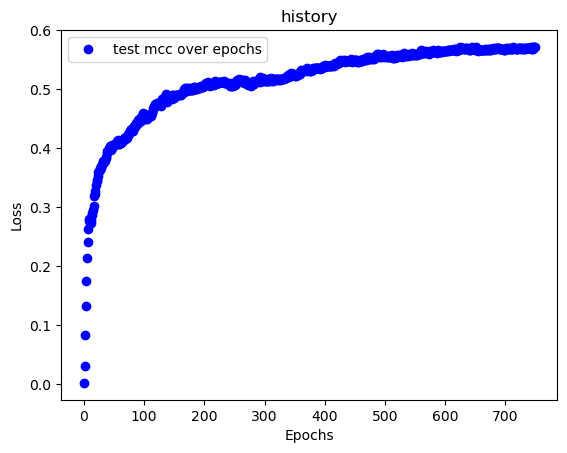

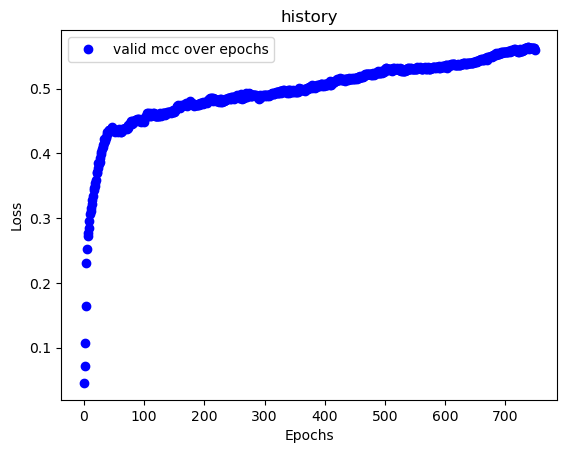

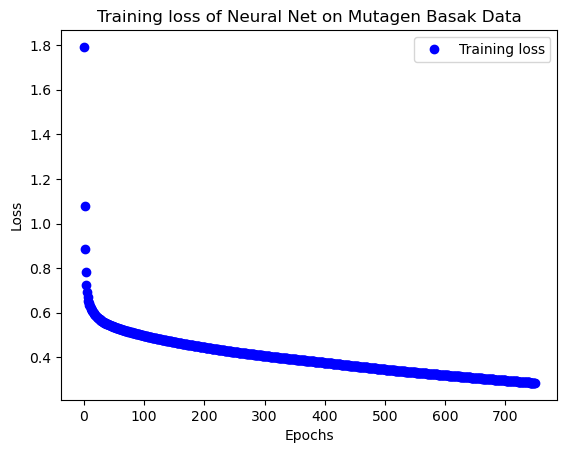

optimal mcc of 0.5707711282775974 at a threshold of 0.37
44/44 [==============================] - 0s 435us/step
validation metrics of:
positives in data 759
negatives in data 630 

fn count = 99
tn count = 402
tp count = 660
fp count = 228 

net accuracy = 0.7645788336933045
positive accuracy = 0.8695652173913043
negative accuracy = 0.638095238095238 

fpr = 0.3619047619047619
tpr = 0.8695652173913043 

f1 score = 0.8014571948998178
mcc = 0.5263070068806281
cohen Kappa = 0.516650544482861


In [27]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
model_list = []
validlist = []
testdat = []
threshlist = []

dfarray, tempset = train_test_split(targetdata, test_size=0.2, random_state=seed, stratify = targetdata['Toxicity_Values'])
trainset, testset = train_test_split(dfarray, test_size=0.2, random_state=seed)

ytrain = trainset.iloc[:, 1].values
xtrain = trainset.iloc[:, 2:]

ytest = testset.iloc[:, 1].values
xtest = testset.iloc[:, 2:]
tempset = tempset.to_numpy()
yvalid = []
xvalid = []
for row in tempset:
    yvalid.append(row[1])
    xvalid.append(row[2:])
    


# Determines layer size and input/output
# Here it turns the 334 one hot encoded features to 42
keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()
length = len(xtrain.columns)
temp = length
# Encoder Creation
enc_in = keras.Input(shape=(length, 1))
x = keras.layers.Flatten()(enc_in)
# Additional encoder layers
x = keras.layers.Dense(90, activation="relu")(x)
x = keras.layers.Dense(45, activation="relu")(x)
x = keras.layers.Dense(10, activation="relu")(x)
enc_out = keras.layers.Dense(1, activation="sigmoid")(x)
autoencoder = keras.Model(enc_in, enc_out, name='autoencoder')
# Optimiser
optimise = tf.keras.optimizers.Adam(learning_rate=0.00001)

autoencoder.compile(optimise, loss='binary_crossentropy')
autoencoder.summary()

#Runs and creates the autoencoder and outputs parameters to a specs file
ytrain = np.array(ytrain)
epochs = 750
batchsize = 16
losshistory = []

minloss = 1
bestepoch = 0
predhistory= []
validhistory = []
for epoch in range(epochs):
    verb = 1
    if epoch % 50 != 0:
        verb = 0
    logs = autoencoder.fit(
    xtrain,
    ytrain,
    verbose = verb,
    epochs=1,
    batch_size=batchsize),
    validation_split=0.2,

    #autoencoder.save(str(f"models/AE-{epoch+1}.keras"))
    loss = logs[0].history['loss'][0]
    losshistory.append(loss)
    if loss < minloss:
        minloss = loss
        bestepoch = epoch
    
    
    preds = autoencoder.predict(xtest, verbose = 0)
    maxval = 0
    for threshold in np.arange(0, 1, 0.01):
        newval = nnmetrics(preds, ytest, threshold)[12]
        if newval > maxval:
            maxval = newval
    predhistory.append(maxval)
    
    xvalid = np.asarray(xvalid).astype('float32')
    preds = autoencoder.predict(xvalid, verbose = 0)
    maxval = 0
    for threshold in np.arange(0, 1, 0.01):
        newval = nnmetrics(preds, yvalid, threshold)[12]
        if newval > maxval:
            maxval = newval
    validhistory.append(maxval)
    

#autoencoder.save(str(f"test/AE-{epoch+1}.keras"))
model_list.append(autoencoder)

preds = autoencoder.predict(xtest)

epochcount = range(epochs)
plt.figure()
plt.plot(epochcount, predhistory, 'bo', label='test mcc over epochs')
plt.title('history')
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(epochcount, validhistory, 'bo', label='valid mcc over epochs')
plt.title('history')
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


epochcount = range(epochs)
plt.figure()
plt.plot(epochcount, losshistory, 'bo', label='Training loss')
plt.title('Training loss of Neural Net on Mutagen Basak Data')
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#acc curve creation
acclist = []
thresholdlist = []
maxval = 0
bestthresh = 0
for threshold in np.arange(0, 1, 0.01):
    newval = nnmetrics(preds, ytest, threshold)[12]
    acclist.append(newval)
    thresholdlist.append(threshold)
    if newval > maxval:
        maxval = newval
        bestthresh = threshold
threshlist.append(bestthresh)
testdat.append(maxval)
y_values = acclist
x_values = thresholdlist

print('optimal mcc of', maxval, 'at a threshold of', bestthresh)


#check models onto validation set, printing various metrics
xvalid = np.asarray(xvalid).astype('float32')
preds = autoencoder.predict(xvalid)
results = nnmetrics(preds, yvalid, bestthresh)
validlist.append(results)
print('validation metrics of:')
print('positives in data', results[0])
print('negatives in data', results[1], '\n')
print('fn count =', results[2])
print('tn count =', results[3])
print('tp count =', results[4])
print('fp count =', results[5], '\n')
print('net accuracy =', results[6])
print('positive accuracy =', results[7])
print('negative accuracy =', results[8], '\n')
print('fpr =', results[9])
print('tpr =', results[10], '\n')
print('f1 score =',results[11])
print('mcc =',results[12])
print('cohen Kappa =',results[13])

In [ ]:
#get x and y values for the final validation set
import statistics

toxvals = []
fingerprints = []
for row in tempset:
    toxvals.append(row[1])
    fingerprints.append(row[2:])

#calculates consensus of models on each fingerprint in the final validation set
consensuslist = []
predictions = []

for fp in fingerprints:
    consensus = -1
    fp = fp.reshape(1, -1)
    fp = np.asarray(fp).astype('float32')
    #appends each model's prediction to a list
    predlist = []
    for model in model_list:
        preds = model.predict(fp, verbose = 0)
        predlist.append(preds)
    predictions.append(predlist)
    
    #finds number of 0s in the prediction list
    zercount = 0
    loops = 0
    for modelpreds in predlist:
        if modelpreds < threshlist[loops]:
            zercount = zercount + 1
    loops = loops + 1
    
    #as there are 5 models, if there are less than 3 0s predicted, the consensus is 1
    if zercount < 3 :
        consensus = 1
    else:
        consensus = 0
    consensuslist.append(consensus)
    
#calculate and print metrics
results = metriccalc(consensuslist, toxvals)
print('validation metrics of:')
print('positives in data', results[0])
print('negatives in data', results[1], '\n')
print('fn count =', results[2])
print('tn count =', results[3])
print('tp count =', results[4])
print('fp count =', results[5], '\n')
print('net accuracy =', results[6])
print('positive accuracy =', results[7])
print('negative accuracy =', results[8], '\n')
print('fpr =', results[9])
print('tpr =', results[10], '\n')
print('f1 score =',results[11])
print('mcc =',results[12])
print('cohen Kappa =',results[13])

In [ ]:
#with open('/Users/james/Documents/Honours/practhesisprep/figure prep/radarplotdata.txt', 'a') as f:
#    print('Chemopy Mutagen NN Consensus MCC =', results[12] , file=f)

In [ ]:
testdat

In [ ]:
validdat